Code partly from OpenAI Cookbook
https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [1]:
import pandas as pd
import os
import json
import openai
import time
import seaborn as sns
import matplotlib.pyplot as plt

import cookbook_function as cbf

In [2]:
os.environ['TestKey3'] = 'sk-proj-GL73kbRwhRpgN3EmXz1YT3BlbkFJEMJhTsinxQDel42BZdNz' 
client = openai.OpenAI(api_key=os.environ['TestKey3'])
headers = {
    "Authorization": f"Bearer {os.environ['TestKey3']}"
}

Validate Data Format

In [3]:
# read in ft messages for generation task
data_paths = ["data/finetuning_data/train_gen.jsonl",
              "data/finetuning_data/val_gen.jsonl",
              "data/finetuning_data/test_gen.jsonl"]

# Load the dataset
datasets=[]
for data_path in data_paths:
    cbf.validate_jsonl(data_path)
    with open(data_path, 'r', encoding='utf-8') as f:
        dataset = [json.loads(line) for line in f]
        print(type(dataset))
    datasets.append(dataset)
    # Initial dataset stats
    print("{} :".format(data_path))
    print("Num examples:", len(dataset))
    print("First example:")
    for message in dataset[0]["messages"]:
        print(message)
    

Valid jsonl file
<class 'list'>
data/finetuning_data/train_gen.jsonl :
Num examples: 21
First example:
{'role': 'system', 'content': "Imagine you are an experienced policymaker in the European Parliament. When provided with a legislative proposal supported by either a left- or right-leaning, a general or no majority, your task is to modify the text to potentially gain support from counterfactual majority. Return the revised full text of the proposal with changes highlighted. If the opposing majority would fundamentally reject the proposal based on its topic or core principles, respond with: 'A [left/right] majority would reject the proposal.'"}
{'role': 'user', 'content': 'Supporting majority: None, alter text to: Right majority. Proposal: Listing the third countries whose nationals must be in possession of visas when crossing the external borders and those whose nationals are exempt from that requirement (Kosovo). The proposed Regulation aims to transfer the reference to ‘Kosovo’ from

In [4]:
# check for format errors
for dataset in data_paths:
    cbf.check_format(dataset)

Found errors:
data_type: 36
Found errors:
data_type: 34
Found errors:
data_type: 35


In [5]:
# check for missing data, distribution of messages in each conversation,
# distribution of tokens per conversation, print token limit warnings

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for dataset in datasets:
    for ex in dataset:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(cbf.num_tokens_from_messages(messages))
        assistant_message_lens.append(cbf.num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    cbf.print_distribution(n_messages, "num_messages_per_example")
    #print_distribution(convo_lens, "num_total_tokens_per_example")
    cbf.print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 4096 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 7, 262
mean / median: 68.19047619047619, 55.0
p5 / p95: 24.0, 124.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 7, 262
mean / median: 69.16, 55.0
p5 / p95: 27.6, 122.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 2, 3
mean / median: 2.8333333333333335, 3.0
p5 / p95: 2.0, 3.0

#

Estimate costs

In [6]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(datasets[0]) # only training data
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~19819 tokens that will be charged for during training
By default, you'll train for 4 epochs on this dataset
By default, you'll be charged for ~79276 tokens


Upload validated files to OpenAI API

In [7]:
# upload validated data file to OpenAI API

train_upload = client.files.create(
  file=open("data/finetuning_data/train_gen.jsonl", "rb"),
  purpose="fine-tune"
  )
val_upload = client.files.create(
  file=open("data/finetuning_data/val_gen.jsonl", "rb"),
  purpose="fine-tune"
)
print("Uploaded training file id:", train_upload.id)
print("Uploaded validation file id:", val_upload.id)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"


Uploaded training file id: file-Z0Xg4DUzJBNwRBZJPfvF6cRz
Uploaded validation file id: file-O8N0QakHGqv2HyHyvM2nRxJ0


Create Fine-Tuning Jobs via OpenAI Software Development Kit

In [8]:
# # Process jobs
# all_job_ids = cbf.process_jobs(
#     [2, 5, 10],
#     [2, 4, 8], 
#     [1, 2], 
#     train_upload, 
#     val_upload, 
#     1
#     )
# print(all_job_ids)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"
INFO:cookbook_function:Job created with ID ftjob-WzXCOlT9AigoGSCy71boHpDM
INFO:cookbook_function:Processing hyperparameters (lr=2, epoch=2, batch=2)
INFO:cookbook_function:Rate limiting: Sleeping for 60.00 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"
INFO:cookbook_function:Job created with ID ftjob-RmdaXaTILXsf9BiXFMyadGls
INFO:cookbook_function:Processing hyperparameters (lr=2, epoch=4, batch=1)
INFO:cookbook_function:Rate limiting: Sleeping for 60.00 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"
INFO:cookbook_function:Job created with ID ftjob-nJp9nIX6mIXwLqxc5rGTyjgO
INFO:cookbook_function:Processing hyperparameters (lr=2, epoch=4, batch=2)
INFO:cookbook_function:Rate limiting: Sleeping for 60.00 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 42

['ftjob-WzXCOlT9AigoGSCy71boHpDM', 'ftjob-RmdaXaTILXsf9BiXFMyadGls', 'ftjob-nJp9nIX6mIXwLqxc5rGTyjgO', 'ftjob-wU87xDJDs95rznFS0eChMsMq', 'ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE', 'ftjob-GTNZyACXSdOl9OWe9Klr6zwy', 'ftjob-hcf1z1ChnoLAuYWG0zfQ6OEy', 'ftjob-pPDRuBrrgeIeE0XIwICulSCn', 'ftjob-MqWKaydI6e9LWIrtpiFOncGX', 'ftjob-RZLyRcFRhsFuKxHa7U2k3kW1', 'ftjob-bpbhGYcXNE7oOfriyAmeDHD5', 'ftjob-bmWtknW0afasIHIu0V02kyQ6']


Getting Metrics / Evaluation

In [9]:
# Wait ten minutes before extracting the results to 
# give the API time to process the last jobs
time.sleep(600)

# Extract information about the jobs
all_results = cbf.extract_job_info(all_job_ids)
display(all_results)

# set index of all_results to job_id
all_results.set_index("job_id", inplace=True)

INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-WzXCOlT9AigoGSCy71boHpDM "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-WzXCOlT9AigoGSCy71boHpDM/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-WzXCOlT9AigoGSCy71boHpDM/events?limit=10&after=ftevent-kkD5NR0vNA3rlGs7NgXFnxyQ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-WzXCOlT9AigoGSCy71boHpDM/events?limit=10&after=ftevent-nxwjTIPv9owDWd186RIOQY62 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-WzXCOlT9AigoGSCy71boHpDM/events?limit=10&after=ftevent-pUIyhy4LQbC8KqDq8sj4iHzn "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-WzXCOlT9AigoGSCy71boHpDM/events?limit=10&after=ftevent-wpCOxNSdGCxJ6tiupfj89H4t "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://a

,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name
0,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"[ftevent-rpNjppl3znPTkS80KR7uavt2, ftevent-eAf...",[file-ibR4DJ3iary0FhDuy6uqyuFQ]
1,ftjob-RmdaXaTILXsf9BiXFMyadGls,2.0,2,2,succeeded,"[ftevent-1UeSBUkVKVGrl8JtdZ1cmf5u, ftevent-etp...",[file-Kx07I3JpkRb3qzC4TEa3X5d4]
2,ftjob-nJp9nIX6mIXwLqxc5rGTyjgO,2.0,4,1,succeeded,"[ftevent-c3nnDfj83dvOgKhlDJtVzwEm, ftevent-59J...",[file-HeK0toFGg789CJptNJY0xz3F]
3,ftjob-wU87xDJDs95rznFS0eChMsMq,5.0,2,2,succeeded,"[ftevent-RIh2Lkg3DoYSq7iH0IaGKkm4, ftevent-V4x...",[file-wSWNSejpeV6iw4xhTY8lNNdQ]
4,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"[ftevent-nDnmI7lNiARlcM7kyJP380Zh, ftevent-AN4...",[file-QS6nCcAK2kX9keQZ9cokwLG4]
5,ftjob-GTNZyACXSdOl9OWe9Klr6zwy,5.0,8,1,succeeded,"[ftevent-nJYLVdSWicD9E31GJHr4E9XJ, ftevent-LQO...",[file-jGuK1aKyqeTbNwYZjmsy92sJ]
6,ftjob-hcf1z1ChnoLAuYWG0zfQ6OEy,5.0,8,2,succeeded,"[ftevent-CB3MQa1tq9Nx4UT6UyV13gWo, ftevent-hNm...",[file-kbJ7Q4HiBQYOYlYjjmhW5FU3]
7,ftjob-pPDRuBrrgeIeE0XIwICulSCn,10.0,2,1,succeeded,"[ftevent-Theq3SuKHZSwXr94CiI5rGoE, ftevent-SjQ...",[file-wkIXDzPv4k5HnQaDm1btMufj]
8,ftjob-MqWKaydI6e9LWIrtpiFOncGX,10.0,2,2,succeeded,"[ftevent-qJl62tZ4zLSuk4luh7EpawVo, ftevent-dJB...",[file-UjmzKM4glAJdsI8Qyyay3aFd]
9,ftjob-RZLyRcFRhsFuKxHa7U2k3kW1,10.0,4,1,running,"[ftevent-FvROOVHd8982F1au01fuSZP9, ftevent-hUl...",[]


In [64]:
# For each row in column "result_file_name", use the cell value to request
# the file from the OpenAI API using the get_ft_results function and save 
# it in a metrics dataframe 
metrics = pd.DataFrame()
all_metrics = pd.DataFrame()

# iterate over all_results
for index, row in all_results.iterrows():
    # extract the string file id from the list, which only has one element
    if row["result_file_name"]:
        file_id = str(row["result_file_name"][0]).strip()
    metrics = pd.read_csv(cbf.get_ft_results(file_id))
    # set index of metrics to job_id
    metrics["job_id"] = index
    all_metrics = pd.concat([all_metrics, metrics], axis=0)
display(all_metrics)

INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.
INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.
INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.
INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.
INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.
INFO:cookbook_function:Received response for file content.
I

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id
0,1,3.48286,0.44304,3.04240,0.49057,ftjob-WzXCOlT9AigoGSCy71boHpDM
1,2,2.52966,0.52577,2.62349,0.62500,ftjob-WzXCOlT9AigoGSCy71boHpDM
2,3,1.93111,0.59091,2.04805,0.62887,ftjob-WzXCOlT9AigoGSCy71boHpDM
3,4,2.33352,0.55844,1.97411,0.61616,ftjob-WzXCOlT9AigoGSCy71boHpDM
4,5,2.58487,0.42857,2.61507,0.50943,ftjob-WzXCOlT9AigoGSCy71boHpDM
...,...,...,...,...,...,...
17,18,1.16997,0.63889,1.48608,0.67857,ftjob-bmWtknW0afasIHIu0V02kyQ6
18,19,1.27373,0.72662,1.54996,0.63303,ftjob-bmWtknW0afasIHIu0V02kyQ6
19,20,1.72130,0.53552,1.48679,0.67857,ftjob-bmWtknW0afasIHIu0V02kyQ6
20,21,1.44917,0.73134,1.54887,0.64220,ftjob-bmWtknW0afasIHIu0V02kyQ6


In [25]:
# Get checkpoints of all jobs
all_checkpoints = ""

# iterate over all_results
for index, row in all_metrics.iterrows():
    #print(row[index])
    job_id = str(row["job_id"]).strip()
    checkpoints = cbf.get_checkpoint_results(job_id)
    # Add all strings of checkpoints to one
    all_checkpoints = all_checkpoints + checkpoints

print(all_checkpoints)[1:100]

# Save all checkpoints to a file
with open("data/checkpoints_gen.txt", "w") as f:
    f.write(all_checkpoints)

C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_11708\2944436156.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[index])
C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_11708\2944436156.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  job_id = str(row[index]).strip()


0


ERROR:__main__:Error occurred: 404 Client Error: Not Found for url: https://api.openai.com/v1/fine_tuning/jobs/0/checkpoints


UnboundLocalError: cannot access local variable 'decoded_content' where it is not associated with a value

In [67]:
# join all_metrics with all_results on job_id as index
#all_metrics = all_metrics.set_index("job_id")
all_results_metrics = all_metrics.join(all_results, on="job_id")
display(all_results_metrics)
# save all_results_metrics as a global variable
all_results_metrics.to_csv("all_results_metrics.csv")

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name
0,1,3.48286,0.44304,3.04240,0.49057,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"[ftevent-rpNjppl3znPTkS80KR7uavt2, ftevent-eAf...",[file-ibR4DJ3iary0FhDuy6uqyuFQ]
1,2,2.52966,0.52577,2.62349,0.62500,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"[ftevent-rpNjppl3znPTkS80KR7uavt2, ftevent-eAf...",[file-ibR4DJ3iary0FhDuy6uqyuFQ]
2,3,1.93111,0.59091,2.04805,0.62887,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"[ftevent-rpNjppl3znPTkS80KR7uavt2, ftevent-eAf...",[file-ibR4DJ3iary0FhDuy6uqyuFQ]
3,4,2.33352,0.55844,1.97411,0.61616,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"[ftevent-rpNjppl3znPTkS80KR7uavt2, ftevent-eAf...",[file-ibR4DJ3iary0FhDuy6uqyuFQ]
4,5,2.58487,0.42857,2.61507,0.50943,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"[ftevent-rpNjppl3znPTkS80KR7uavt2, ftevent-eAf...",[file-ibR4DJ3iary0FhDuy6uqyuFQ]
...,...,...,...,...,...,...,...,...,...,...,...,...
17,18,1.16997,0.63889,1.48608,0.67857,ftjob-bmWtknW0afasIHIu0V02kyQ6,10.0,8,1,running,"[ftevent-NGdwybDYJB6Ep4MeMIFsvlok, ftevent-5Rz...",[]
18,19,1.27373,0.72662,1.54996,0.63303,ftjob-bmWtknW0afasIHIu0V02kyQ6,10.0,8,1,running,"[ftevent-NGdwybDYJB6Ep4MeMIFsvlok, ftevent-5Rz...",[]
19,20,1.72130,0.53552,1.48679,0.67857,ftjob-bmWtknW0afasIHIu0V02kyQ6,10.0,8,1,running,"[ftevent-NGdwybDYJB6Ep4MeMIFsvlok, ftevent-5Rz...",[]
20,21,1.44917,0.73134,1.54887,0.64220,ftjob-bmWtknW0afasIHIu0V02kyQ6,10.0,8,1,running,"[ftevent-NGdwybDYJB6Ep4MeMIFsvlok, ftevent-5Rz...",[]


,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination
0,0,1,3.48286,0.44304,3.04240,0.49057,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
1,1,2,2.52966,0.52577,2.62349,0.62500,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
2,2,3,1.93111,0.59091,2.04805,0.62887,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
3,3,4,2.33352,0.55844,1.97411,0.61616,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
4,4,5,2.58487,0.42857,2.61507,0.50943,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"


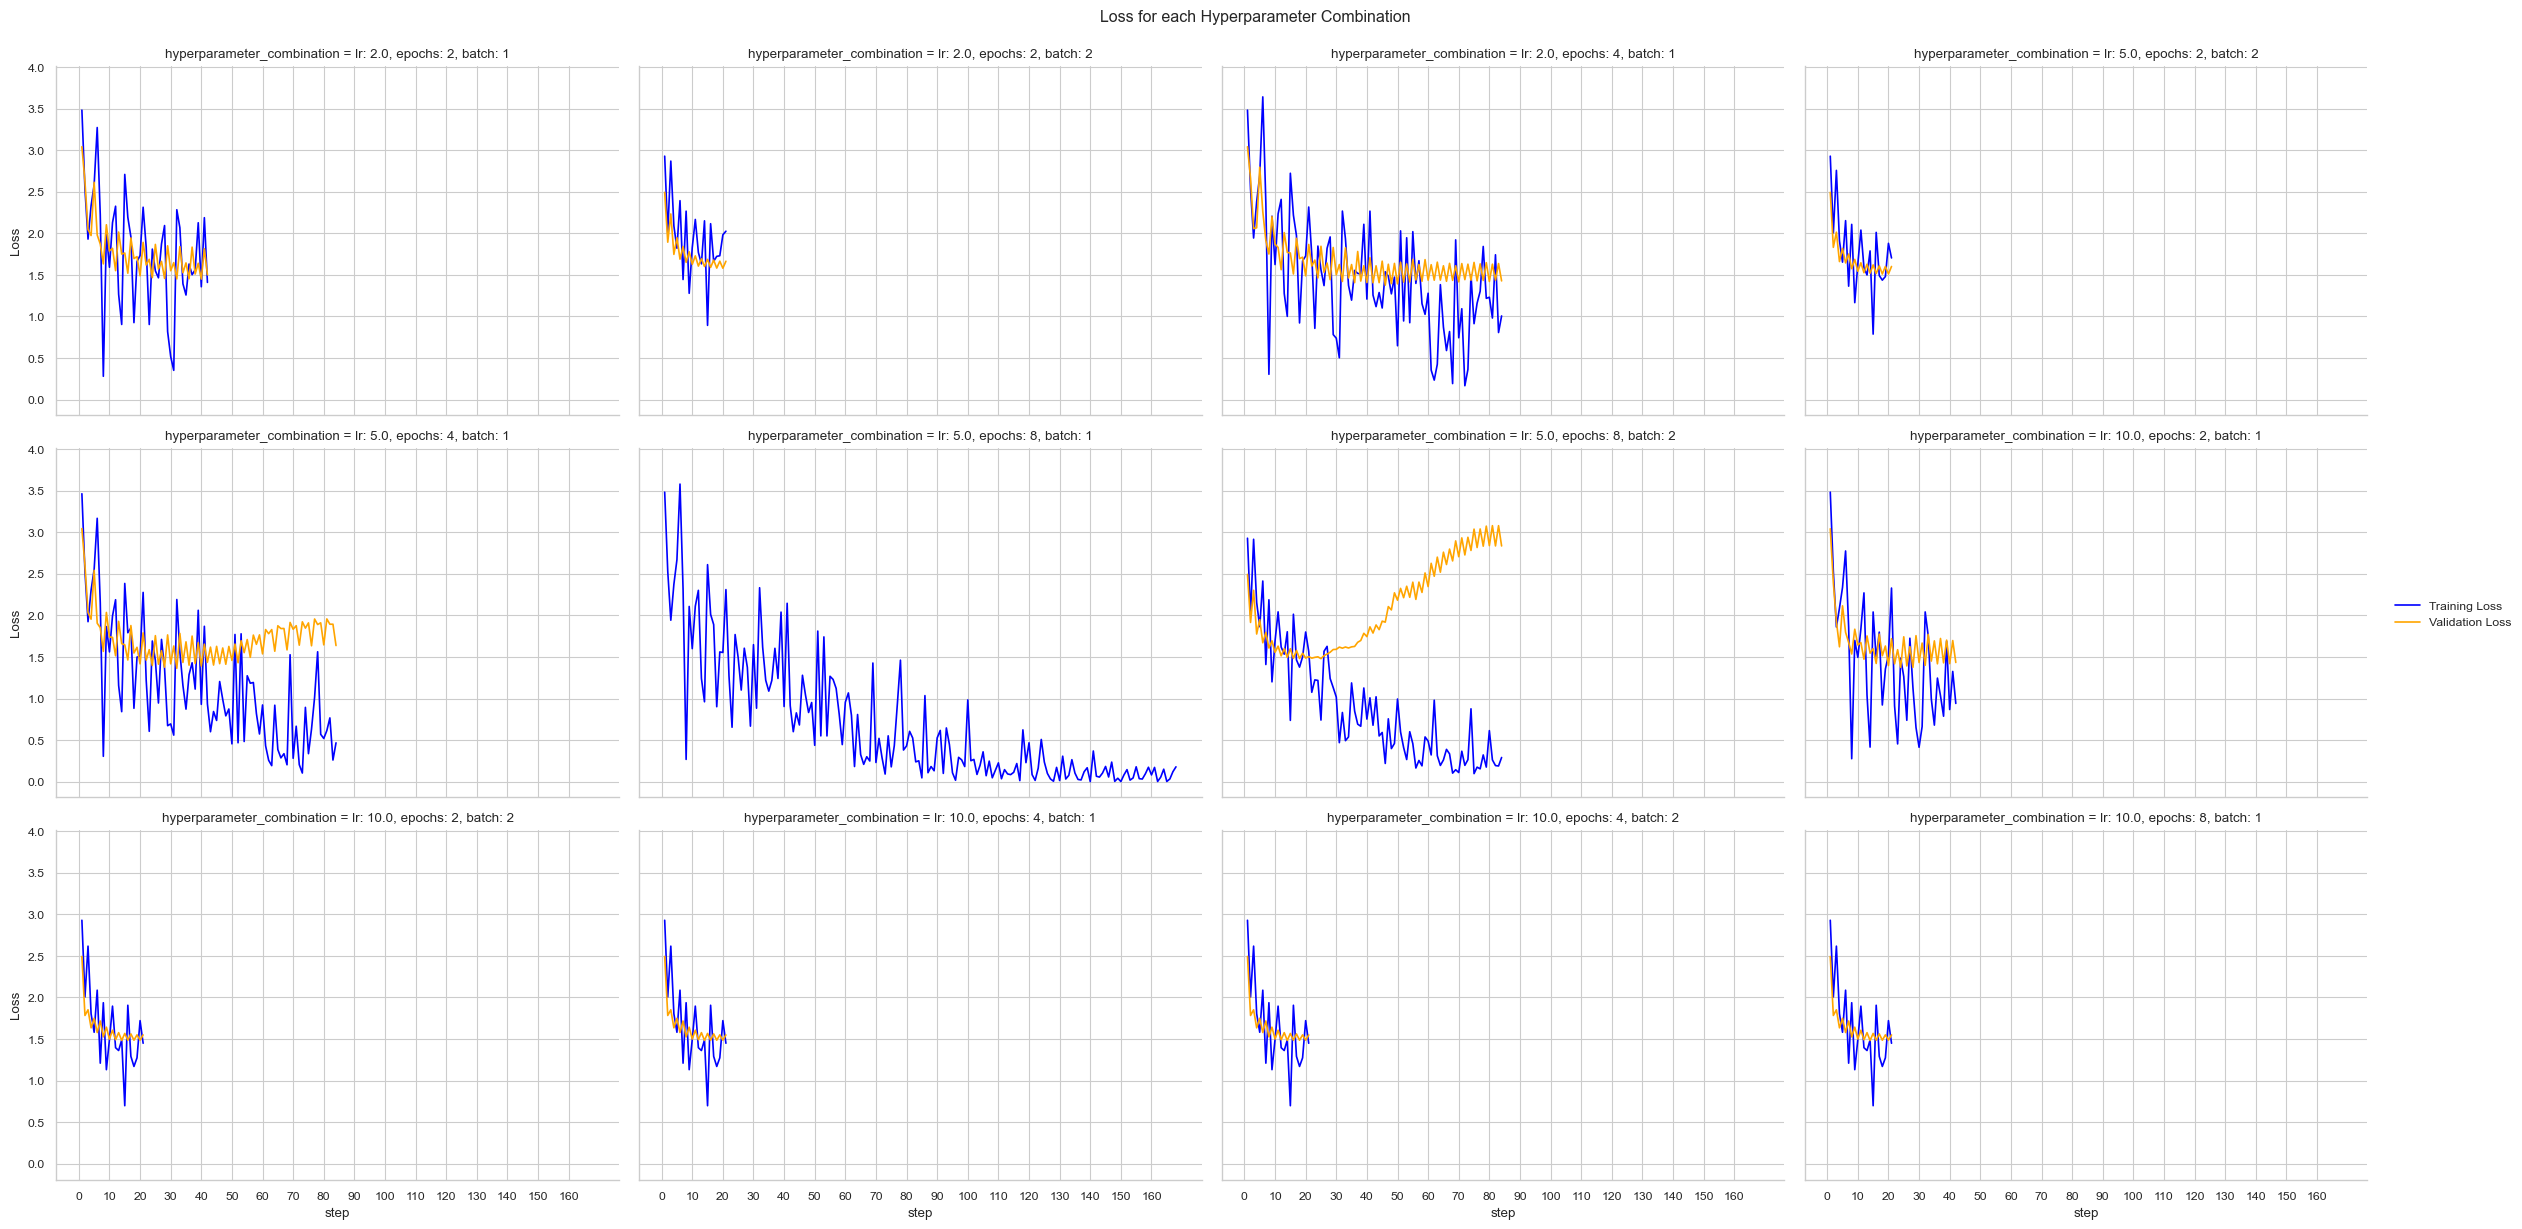

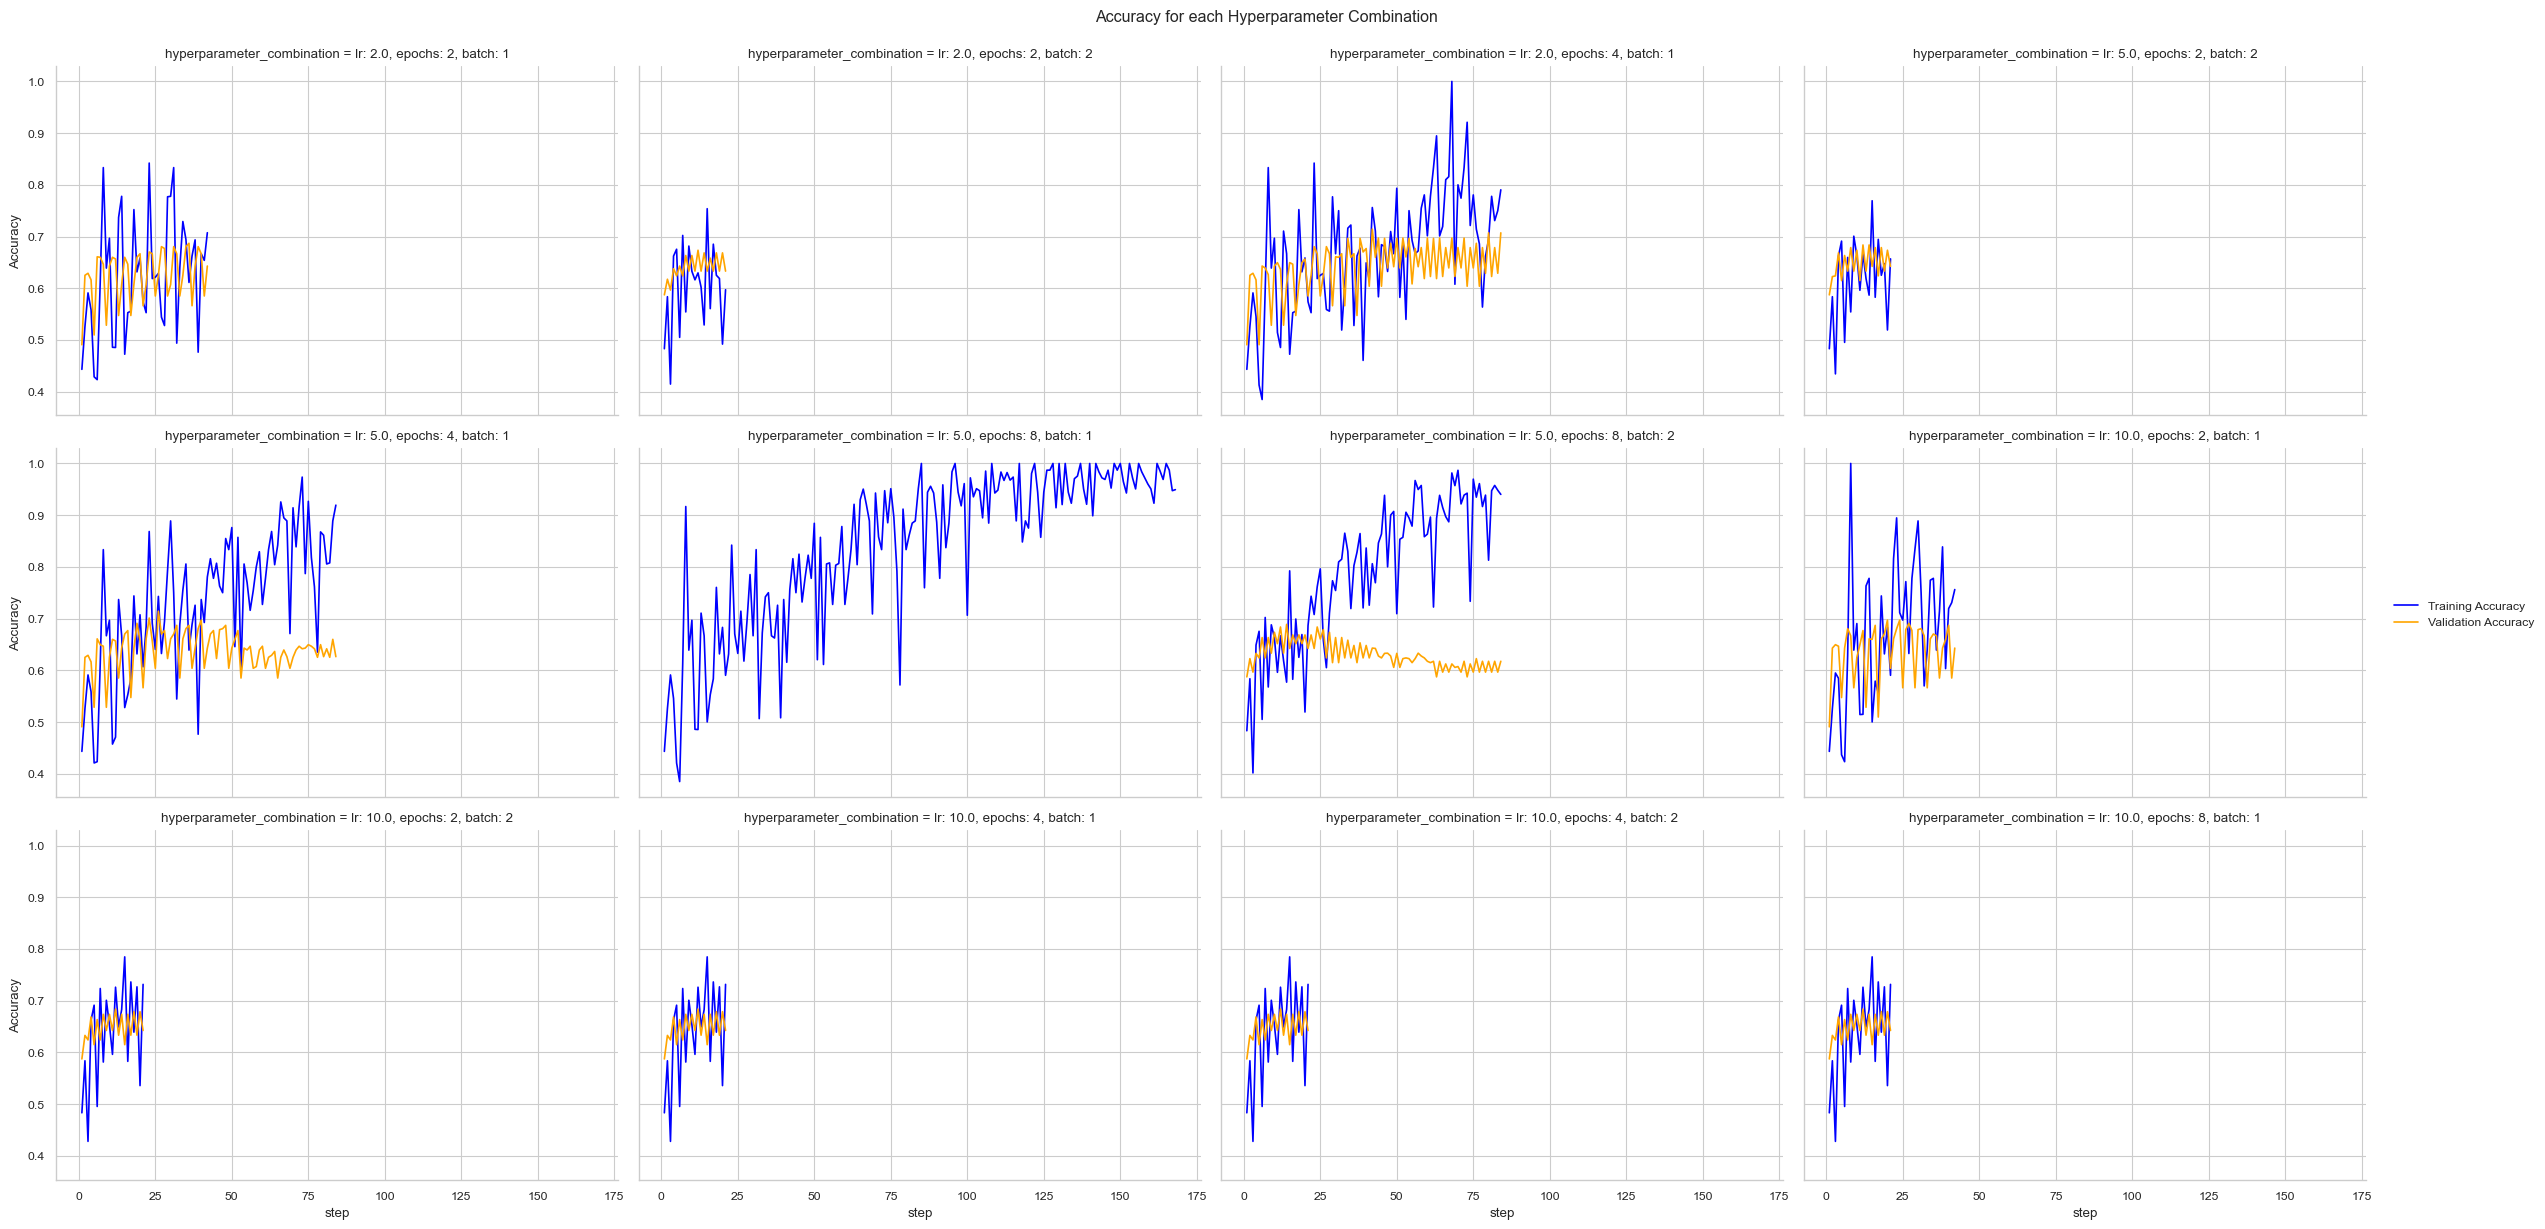

In [90]:
all_results_metrics_copy = pd.read_csv("all_results_metrics.csv")
all_results_metrics_copy["learning_rate_multiplier"] = all_results_metrics_copy["learning_rate_multiplier"].astype(str)

# Create a column to represent each hyperparameter combination
all_results_metrics_copy["hyperparameter_combination"] = (
    "lr: " + all_results_metrics_copy["learning_rate_multiplier"].astype(str) +
    ", epochs: " + all_results_metrics_copy["n_epochs"].astype(str) +
    ", batch: " + all_results_metrics_copy["batch_size"].astype(str)
)

# delete rows where steps == =
all_results_metrics_copy = all_results_metrics_copy[all_results_metrics_copy["step"] != "="]
all_results_metrics_copy = all_results_metrics_copy[all_results_metrics_copy["step"] != "=="]
all_results_metrics_copy = all_results_metrics_copy[all_results_metrics_copy["step"] != "==="]
# Convert steps to integers
all_results_metrics_copy["step"] = all_results_metrics_copy["step"].astype(int)

display(all_results_metrics_copy.head())

# Plot the losses
# grid of subplots: g with FacetGrid function
g = sns.FacetGrid(all_results_metrics_copy,
                  col="hyperparameter_combination",
                  col_wrap=2,
                  height=4,
                  aspect=1.5
                  )
g.map(plt.plot, "step", "train_loss", label="Training Loss", color="blue")
g.map(plt.plot, "step", "valid_loss", label="Validation Loss", color="orange")
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel("Loss")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, all_results_metrics_copy["step"].max(), 10))

g.figure.suptitle('Loss for each Hyperparameter Combination', y=1.02)
plt.show()

# Plot the accuracies
g = sns.FacetGrid(all_results_metrics_copy, col="hyperparameter_combination", col_wrap=4, height=4, aspect=1.5)
g.map(plt.plot, "step", "train_accuracy", label="Training Accuracy",color="blue")
g.map(plt.plot, "step", "valid_mean_token_accuracy", label="Validation Accuracy", color="orange")
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel("Accuracy")

g.figure.suptitle('Accuracy for each Hyperparameter Combination', y=1.02)
plt.show()

# save all_results_metrics_copy as a global variable
all_results_metrics_copy.to_csv("all_results_metrics_copy.csv")

In [95]:
all_results_metrics_copy = pd.read_csv("all_results_metrics_copy.csv")

# Find three most minimal losses to choose the best model
min_loss = all_results_metrics_copy["train_loss"].min()
min_losses = all_results_metrics_copy["train_loss"].nsmallest(3)
display(min_loss)
display(min_losses)
print(f"Models {min_losses.index} are the models with the lowest losses of {min_losses.values}.")

# Find the model with the smallest training AND validation loss
# Calculate sum of each training and validation loss and find smallest sum
all_results_metrics_copy["sum_loss"] = all_results_metrics_copy["train_loss"] + all_results_metrics_copy["valid_loss"]
min_sum_loss = all_results_metrics_copy["sum_loss"].min()
min_sum_losses = all_results_metrics_copy["sum_loss"].nsmallest(3)
display(min_sum_loss)
display(min_sum_losses)
print(f"Models {min_sum_losses.index} are the models with the lowest sum of training and validation losses of {min_sum_losses.values}.")

# save min_sum_losses.index as list of indices
min_sum_losses_indices = min_sum_losses.index.tolist()
print(min_sum_losses_indices)
display(all_results_metrics_copy.loc[min_sum_losses_indices[0]])
display(all_results_metrics_copy.loc[min_sum_losses_indices[1]])
display(all_results_metrics_copy.loc[min_sum_losses_indices[2]])

0.00075

391    0.00075
401    0.00138
416    0.00204
Name: train_loss, dtype: float64

Models Index([391, 401, 416], dtype='int64') are the models with the lowest losses of [0.00075 0.00138 0.00204].


1.6103800000000001

134    1.61038
130    1.62740
124    1.67100
Name: sum_loss, dtype: float64

Models Index([134, 130, 124], dtype='int64') are the models with the lowest sum of training and validation losses of [1.61038 1.6274  1.671  ].
[134, 130, 124]


In [93]:
# print smallest sum of losses of models with combination lr: 5, epochs: 4, batch: 1
display(all_results_metrics_copy[all_results_metrics_copy["hyperparameter_combination"] == "lr: 5.0, epochs: 4, batch: 1"])


,Unnamed: 0.1,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination,sum_loss
168,171,0,1,3.46413,0.44304,3.04463,0.49057,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",6.50876
169,172,1,2,2.52395,0.52577,2.60508,0.62500,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",5.12903
170,173,2,3,1.92451,0.59091,2.03612,0.62887,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",3.96063
171,174,3,4,2.30411,0.55844,1.95472,0.61616,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",4.25883
172,175,4,5,2.55378,0.42063,2.54295,0.52830,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",5.09673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,250,79,80,0.51950,0.86111,1.64582,0.62626,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",2.16532
248,251,80,81,0.61416,0.80556,1.95804,0.64151,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",2.57220
249,252,81,82,0.76711,0.80769,1.89408,0.62500,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",2.66119
250,253,82,83,0.25959,0.88889,1.89438,0.65979,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1",2.15397


Model with job_id ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE has small training loss with comparably low validation loss. Validation loss is less crucial here due to few and diverse validation examples. Small training loss is weighted higher.
Model name: ft:gpt-3.5-turbo-0125:lse:mig-gen:9qiOMnNu

Using fine-tuned model via Playground or via code

In [18]:
test_message = []
# read in jsonl and convert to list of dictionaries
with open("data/finetuning_data/test_gen.jsonl", "r") as f:
    for line in f:
        test_message.append(json.loads(line))

headers=  {'Authorization': f'Bearer sk-proj-GL73kbRwhRpgN3EmXz1YT3BlbkFJEMJhTsinxQDel42BZdNz'}

# make a request to the new model with each test message
for i in range(len(test_message)):
    completion = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:lse:mig-gen:9qiOMnNu",
        messages = test_message[i]["messages"]
        )
    print(completion.choices[0].message)

ChatCompletionMessage(content='These Amendments are likely to be proposed by the right majority: \n\nThe definition of the type of employment should cover work in the context of part-time and fixed-term contracts [Amendment delete: , seasonal work, ], work placement [Amendment delete: and ] temporary agency work [, in accordance with the relevant Union law and/or national law and practices].', role='assistant', function_call=None, tool_calls=None)
ChatCompletionMessage(content='Amendment to further change: The Member States should also take all necessary measures to ensure that recruitment procedures do not discriminate against applicants on the basis of their gender, age, racial or ethnic origin, religion or belief, sexual orientation, or disability.', role='assistant', function_call=None, tool_calls=None)
ChatCompletionMessage(content="The right majority could propose to delete the part 'antry, integration of  and their further integration into Labour markets'", role='assistant', fun

To do
- diese File nicht mehr anfassen
- und ft cell in dieser file auskommentieren
- mit dieser Vorlage die classification finetuning machen
- qualitative results in aktuelles doc schreiben, jetzt weiß ich es noch, das passt auch noch sicher zur Analyse
- dann irgendwann die ganze Struktur vom aktuellen introduction file umschreiben, während classification fine-tuning läuft.

Using the classification model for generation

In [ ]:
# Process jobs
# Fine-tuning the fine-tuned classifier model with the best hyperparameters
gen_job_ids = cbf.process_jobs(
    [5],
    [8], 
    [1], 
    train_upload, 
    val_upload, 
    1,
    model="ft:gpt-3.5-turbo-0125:lse:mig-gen:9rLoNStH"
    )
print(gen_job_ids)

